# 📊 Proyecto: Mantenimiento Predictivo de Motores
Este proyecto aplica Machine Learning para predecir si un motor industrial fallará en los próximos 30 días.
Los datos fueron generados simulando registros de sensores, mantenimientos y fallas.
Fueron integrados con SQL Server, exportados a CSV y serán analizados en Python usando técnicas de clasificación binaria.


## 🎯 Definición del problema

El mantenimiento de motores industriales representa un desafío clave en la gestión operativa de plantas productivas. Las fallas imprevistas generan paradas no programadas, costos elevados por urgencias y pérdida de productividad.

Este proyecto aplica técnicas de Machine Learning para **predecir si un motor fallará en los próximos 30 días**, a partir de datos históricos de sensores, mantenimientos y fallas. El objetivo es anticipar posibles fallas con suficiente anticipación para permitir acciones preventivas y optimizar recursos.

---

## 🧠 Pregunta del proyecto

> **¿Podemos predecir con datos de sensores si un motor está en riesgo de falla en los próximos 30 días?**

---

In [33]:
# Carga de librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


## 📥 Carga del Dataset

Vamos a cargar el archivo `sensores_maestra.csv` que contiene las lecturas diarias de los motores, junto con información de mantenimiento, fallas y la variable objetivo `falla_en_30_dias`.


In [34]:
# Subí el archivo manualmente en Colab antes de correr esta celda
ruta = '/content/sensores_maestra.csv'

# Cargar el archivo en un DataFrame, especificando el delimitador como coma
# y saltando las primeras 7 filas para usar la fila 8 como encabezado.
df = pd.read_csv(ruta, sep=';')

# Ver las primeras filas y las columnas
df.head()

,fecha,motor_id,corriente,temperatura,vibracion,tipo_mtto,fecha_mtto,tipo_falla,fecha_falla,falla_en_30_dias
0,2025-01-01,MTR_001,972,7509,306,NaN,NaN,mecÃ¡nica,2025-06-22,0
1,2025-01-02,MTR_001,899,7045,242,NaN,NaN,mecÃ¡nica,2025-06-22,0
2,2025-01-03,MTR_001,1027,7402,294,NaN,NaN,mecÃ¡nica,2025-06-22,0
3,2025-01-04,MTR_001,859,728,259,NaN,NaN,mecÃ¡nica,2025-06-22,0
4,2025-01-05,MTR_001,954,7575,204,NaN,NaN,mecÃ¡nica,2025-06-22,0


## 🧾 Descripción del Dataset

El dataset `sensores_maestra.csv` fue generado a partir de múltiples fuentes simuladas (sensores, mantenimiento y fallas) y unificado mediante SQL Server. Cada fila representa una observación diaria de un motor industrial.

### 📄 Columnas principales:

- `fecha`: Fecha del registro (formato YYYY-MM-DD)
- `motor_id`: Identificador del motor (ejemplo: MTR_001)
- `corriente`: Corriente eléctrica en amperios (A) medida ese día
- `temperatura`: Temperatura del motor en grados Celsius (°C)
- `vibracion`: Nivel de vibración en mm/s (valor RMS)
- `tipo_mtto`: Tipo de mantenimiento realizado ese día, si corresponde (lubricación, ajuste, etc.)
- `fecha_mtto`: Fecha en la que se registró ese mantenimiento (puede ser NaN)
- `tipo_falla`: Clasificación de la falla (eléctrica, mecánica, sobrecalentamiento), si ocurrió
- `fecha_falla`: Fecha en la que ocurrió la falla (puede ser NaN)
- `falla_en_30_dias`: Variable objetivo binaria:
  - `1` → El motor fallará dentro de los 30 días posteriores a la fecha del registro
  - `0` → No se espera que falle en ese rango de tiempo

Este dataset permite entrenar un modelo de clasificación supervisada para prevenir fallas y optimizar el mantenimiento industrial.


## 🔍 Análisis exploratorio (EDA)

Analizamos la estructura del dataset, verificamos valores nulos y observamos la distribución de la variable objetivo `falla_en_30_dias`.


In [35]:
# Info general del DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   fecha             1800 non-null   object
 1   motor_id          1800 non-null   object
 2   corriente         1800 non-null   int64 
 3   temperatura       1800 non-null   int64 
 4   vibracion         1800 non-null   int64 
 5   tipo_mtto         30 non-null     object
 6   fecha_mtto        30 non-null     object
 7   tipo_falla        1080 non-null   object
 8   fecha_falla       1080 non-null   object
 9   falla_en_30_dias  1800 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 140.8+ KB


In [42]:
# Cantidad de valores nulos por columna
df.isnull().sum()

,0
fecha,0
motor_id,0
corriente,0
temperatura,0
vibracion,0
tipo_mtto,1770
fecha_mtto,1770
tipo_falla,720
fecha_falla,720
falla_en_30_dias,0


In [43]:
# Estadísticas descriptivas
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
corriente,1800.0,1062.51,547.27,72.0,913.0,1014.0,1111.00,4704.0
temperatura,1800.0,7086.33,2223.39,670.0,7258.0,7543.0,7843.25,12582.0
vibracion,1800.0,291.63,205.11,14.0,215.0,253.0,297.00,1622.0
falla_en_30_dias,1800.0,0.10,0.30,0.0,0.0,0.0,0.00,1.0


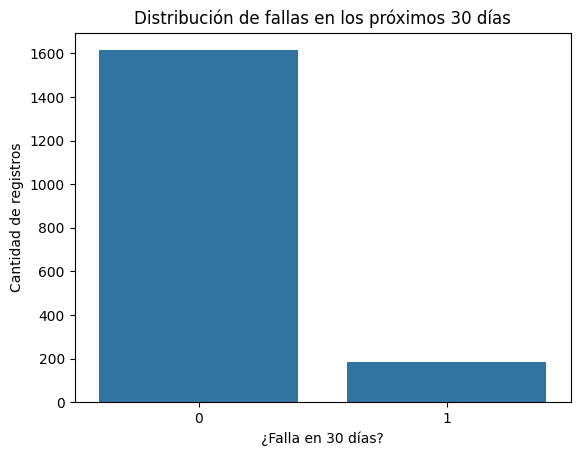

In [44]:
# Visualización de la variable objetivo
sns.countplot(x='falla_en_30_dias', data=df)
plt.title("Distribución de fallas en los próximos 30 días")
plt.xlabel("¿Falla en 30 días?")
plt.ylabel("Cantidad de registros")
plt.show()

## 🧪 Preprocesamiento

Seleccionamos solo las variables numéricas relevantes para el modelo (`corriente`, `temperatura`, `vibracion`) y la variable objetivo `falla_en_30_dias`.
También eliminamos registros con valores faltantes.


In [39]:
# Selección de columnas relevantes
columnas_utiles = ['corriente', 'temperatura', 'vibracion', 'falla_en_30_dias']
df_modelo = df[columnas_utiles].dropna()

# Verificamos la nueva forma del dataset
df_modelo.shape

(1800, 4)

In [40]:
# Separación en X (features) e y (target)
X = df_modelo.drop('falla_en_30_dias', axis=1)
y = df_modelo['falla_en_30_dias']

In [41]:
# Vemos df_modelo
print("🔍 Tamaño del dataset:")
print(df_modelo.shape)

print("\n🧼 Valores nulos por columna:")
print(df_modelo.isnull().sum())

print("\n📊 Distribución de la variable objetivo:")
print(df_modelo['falla_en_30_dias'].value_counts())

print("\n📈 Estadísticas descriptivas:")
print(df_modelo.describe().T[['mean', 'std', 'min', 'max']])


🔍 Tamaño del dataset:
(1800, 4)

🧼 Valores nulos por columna:
corriente           0
temperatura         0
vibracion           0
falla_en_30_dias    0
dtype: int64

📊 Distribución de la variable objetivo:
falla_en_30_dias
0    1614
1     186
Name: count, dtype: int64

📈 Estadísticas descriptivas:
                         mean          std    min      max
corriente         1062.511111   547.266932   72.0   4704.0
temperatura       7086.330556  2223.390847  670.0  12582.0
vibracion          291.628889   205.109044   14.0   1622.0
falla_en_30_dias     0.103333     0.304478    0.0      1.0


## 🧠 División en entrenamiento y testeo

Dividimos el dataset en datos de entrenamiento y testeo con una proporción 70/30, manteniendo el balance de clases mediante estratificación.


In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("🔹 Tamaño de X_train:", X_train.shape)
print("🔹 Tamaño de X_test :", X_test.shape)
print("🔹 Distribución en y_train:")
print(y_train.value_counts(normalize=True))


🔹 Tamaño de X_train: (1260, 3)
🔹 Tamaño de X_test : (540, 3)
🔹 Distribución en y_train:
falla_en_30_dias
0    0.896825
1    0.103175
Name: proportion, dtype: float64


## 🌳 Entrenamiento del modelo: Random Forest

Entrenamos un modelo de clasificación binaria con Random Forest para predecir si un motor fallará en los próximos 30 días.


In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Inicializar y entrenar el modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predecir con los datos de test
y_pred = clf.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       484
           1       0.52      0.45      0.48        56

    accuracy                           0.90       540
   macro avg       0.73      0.70      0.71       540
weighted avg       0.89      0.90      0.90       540



## 📉 Matriz de Confusión

La matriz de confusión permite visualizar cuántos casos fueron correctamente clasificados y cuántos fueron confundidos entre sí.


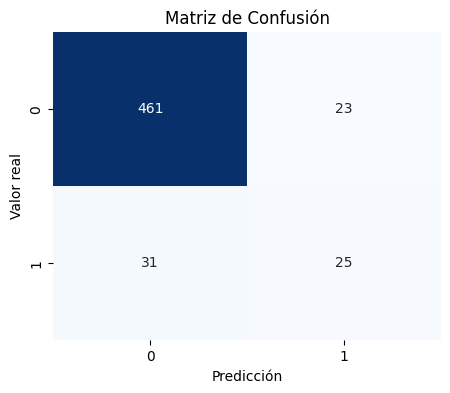

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización con heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()


## 📈 Curva ROC y AUC

La curva ROC (Receiver Operating Characteristic) muestra la relación entre la tasa de verdaderos positivos (recall) y la tasa de falsos positivos a diferentes umbrales. El AUC (Área Bajo la Curva) resume esta capacidad de separación en un solo número entre 0 y 1.


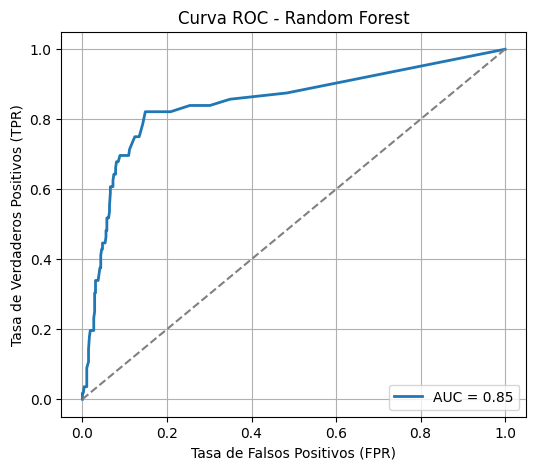

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilidades de predicción para la clase 1
y_proba = clf.predict_proba(X_test)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea base
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## ✅ Resultados clave

- **AUC (ROC):** 0.85 → muy buena capacidad predictiva
- **F1-score clase positiva (falla):** 0.48 → nivel aceptable de detección para un primer modelo
- **Curva ROC y matriz de confusión** muestran que el modelo puede anticipar gran parte de las fallas con bajo nivel de falsas alarmas.

---

Este sistema puede ser integrado en un entorno industrial para emitir alertas tempranas y priorizar inspecciones, aumentando la eficiencia del mantenimiento preventivo y reduciendo el riesgo de fallas inesperadas.


## 📊 Enfoque

- **Tipo de problema**: Clasificación binaria supervisada
- **Variable objetivo**: `falla_en_30_dias` (0 = no falla, 1 = falla)
- **Modelo base usado**: Random Forest
- **Fuentes de datos**: sensores simulados (corriente, temperatura, vibración), historial de mantenimiento, registros de fallas
- **Herramientas**: Python, pandas, scikit-learn, SQL Server, Google Colab

---
